In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/FYP/chest_xray_VGG16_Augmentation>.zip -d /content/extracted_files

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [4]:
# Define dataset paths
base_dir = '/content/extracted_files/chest_xray_VGG16_Augmentation'  # Adjust this path as needed
train_dir = os.path.join(base_dir, '/content/extracted_files/chest_xray_VGG16_Augmentation/train')
test_dir = os.path.join(base_dir, '/content/extracted_files/chest_xray_VGG16_Augmentation/test')


In [5]:
# Define data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)


In [6]:
# Create training and validation datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # VGG16 input size
    batch_size=32,
    class_mode='binary',
    subset='training'
)


Found 4187 images belonging to 2 classes.


In [7]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 1045 images belonging to 2 classes.


In [8]:
# Create test dataset without augmentation
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 624 images belonging to 2 classes.


In [9]:
# Load VGG16 without the top layer
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Freeze the convolutional base
for layer in vgg_base.layers:
    layer.trainable = False


In [11]:
# Build the full model
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


In [12]:
# Compile the model with a specified learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Adjust epochs as needed
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 145s 952ms/step - accuracy: 0.7988 - loss: 0.7289 - val_accuracy: 0.9349 - val_loss: 0.1987
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 107s 777ms/step - accuracy: 0.8971 - loss: 0.2405 - val_accuracy: 0.9321 - val_loss: 0.1803
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 139s 767ms/step - accuracy: 0.9006 - loss: 0.2306 - val_accuracy: 0.9263 - val_loss: 0.1803
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 772ms/step - accuracy: 0.9027 - loss: 0.2308 - val_accuracy: 0.9254 - val_loss: 0.1807
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 106s 771ms/step - accuracy: 0.9166 - loss: 0.2046 - val_accuracy: 0.9368 - val_loss: 0.1551
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 768ms/step - accuracy: 0.9034 - loss: 0.2349 - val_accuracy: 0.9397 - val_loss: 0.1394
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 164s 931ms/step - accuracy: 0.9097 - loss: 0.2224 - val_accuracy: 0.9512 - val_loss: 0.1405
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 122s 777ms/step - accuracy: 0.9194 - loss: 0.19

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 736ms/step - accuracy: 0.8993 - loss: 0.3067
Test Accuracy: 91.51%


In [15]:
# Predict classes on test data
predictions = (model.predict(test_generator) > 0.5).astype("int32")


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step


In [16]:
# Generate Confusion Matrix and Classification Report
print("Confusion Matrix")
print(confusion_matrix(test_generator.classes, predictions))


Confusion Matrix
[[199  35]
 [ 18 372]]


In [17]:
print("Classification Report")
print(classification_report(test_generator.classes, predictions, target_names=test_generator.class_indices.keys()))


Classification Report
              precision    recall  f1-score   support

      NORMAL       0.92      0.85      0.88       234
   PNEUMONIA       0.91      0.95      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.91       624



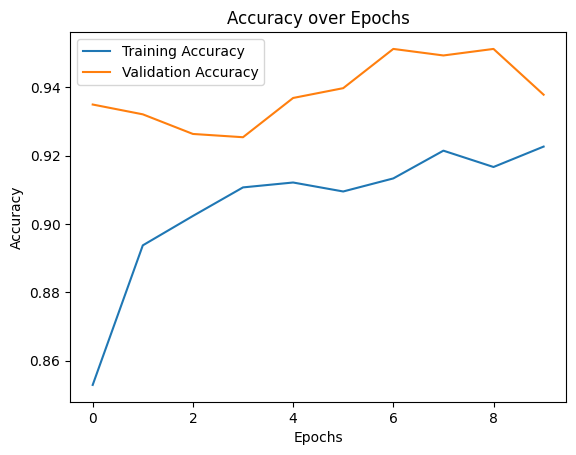

In [18]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


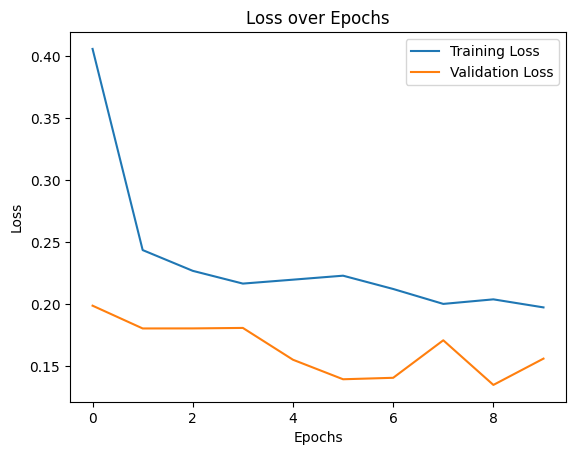

In [19]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
